# Dataset exploration

Each recording is about 900s long. 

The log file has 3s tidbits of sound, we can relate each label to the audio by assuming that the the start of the time is measured by the label of the .wav file.

Listening to the audio, the first positive entry is not very noticeable, the second is audible, so for initial exploration I'll look at this one. 

In [1]:
import pandas as pd

metadata = pd.read_csv(r'C:\Users\NoahB\OneDrive\Desktop\cetacean_detection\nefsc_sbnms_200903_nopp6_ch10\detections\NEFSC_SBNMS_200903_NOPP6_CH10_upcall-detection-log.csv')

Visualize the audio file: 

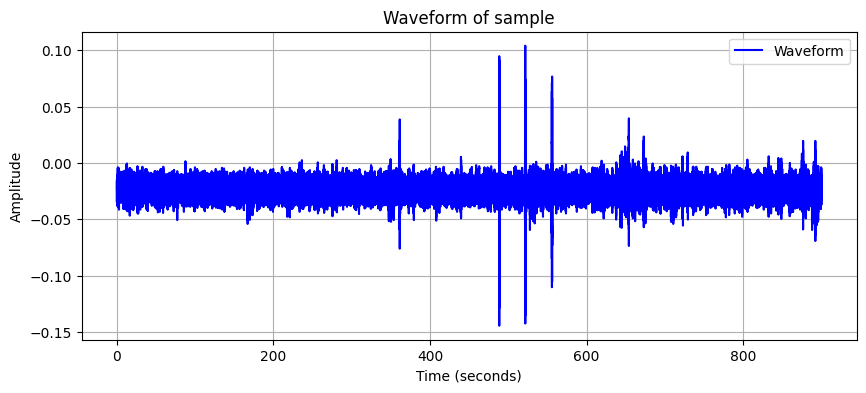

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram
import glob
import os
from datetime import datetime
# %pip install librosa
import librosa
# visualizing a chunk of audio representing a positive sample
# Read the WAV file
recording_folder = r'C:\Users\NoahB\OneDrive\Desktop\cetacean_detection\nefsc_sbnms_200903_nopp6_ch10\source-audio'

wav_files = glob.glob(os.path.join(recording_folder, "*.wav"))
first_postive = wav_files[0]
# sample_rate, data = wavfile.read(first_postive)
y, sr = librosa.load(first_postive, sr=None)  # Keep original sample rate

# plot the audio signal
time_axis = np.linspace(0, len(y) / sr, num=len(y))
plt.figure(figsize=(10, 4))
plt.plot(time_axis, y, label="Waveform", color="blue")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Waveform of sample")
plt.legend()
plt.grid()
plt.show()

Compute the time block for the first sample based on the metadata file

In [3]:
# compute the times for the first positive upcall
time = first_postive.split("NOPP6_EST_")[1].split("_CH10")[0]
# Parse the input date
file_start_time = datetime.strptime(time, "%Y%m%d_%H%M%S")
print("file start time: ", file_start_time)

# calculate the start and end of first chunk of upcall
def remove_timezone(date_str):
    # Parse the input string
    dt = datetime.strptime(date_str[:-6], "%Y-%m-%dT%H:%M:%S")  # Ignore timezone

    # Convert to the desired format
    return dt
first_positive_start_time = remove_timezone(metadata.iloc[1]['Start_DateTime_ISO8601'])
first_positive_end_time = remove_timezone(metadata.iloc[1]['End_DateTime_ISO8601'])
print("first postive window: ", first_positive_start_time, first_positive_end_time)
print("first positive time range:", first_positive_start_time, first_positive_end_time)
# offset for call start and recording start time
start_time = int((first_positive_start_time - file_start_time).total_seconds()) + 1
time_delta = (first_positive_end_time - first_positive_start_time).total_seconds() -1
end_time = start_time + time_delta
print("start time (s): ", start_time)
print("end time (s): ", end_time)
# compute offsets
start_offset = int(start_time * sr)
end_offset = int(end_time * sr)
print("sample_rate: ", sr)
print("offsets: ", start_offset, end_offset)

file start time:  2009-03-28 00:00:00
first postive window:  2009-03-28 00:03:55 2009-03-28 00:03:58
first positive time range: 2009-03-28 00:03:55 2009-03-28 00:03:58
start time (s):  236
end time (s):  238.0
sample_rate:  2000
offsets:  472000 476000


Visualize the waveform of the positive sample: 

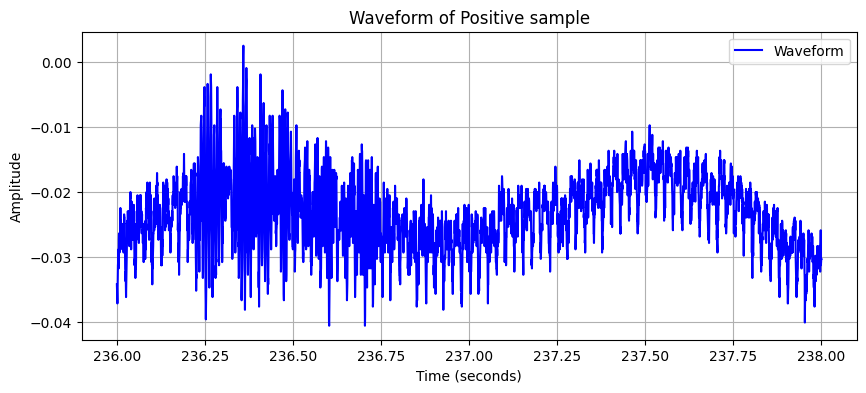

In [4]:
# visualize chunk of wave! 
y_chunk = y[start_offset:end_offset]
time_axis = np.linspace(start_offset / sr, end_offset / sr, num=len(y_chunk))

# Plot waveform chunk
plt.figure(figsize=(10, 4))
plt.plot(time_axis, y_chunk, label="Waveform", color="blue")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Waveform of Positive sample")
plt.legend()
plt.grid()
plt.show()


Visualize the positive wave form with respect to a larger +-10s window: 

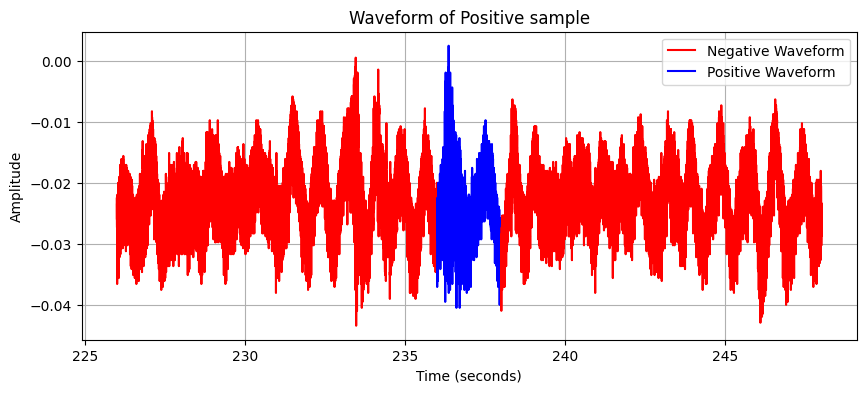

In [5]:
# visualize larger chunk of wave surrounding the positive sample 
larger_start_offset = start_offset - (10 * sr)
larger_end_offset = end_offset + (10 * sr)
y_chunk = y[larger_start_offset:larger_end_offset]
time_axis = np.linspace(larger_start_offset / sr, larger_end_offset / sr, num=len(y_chunk))

# Plot waveform chunk
plt.figure(figsize=(10, 4))

# Plot the portion before the positive sample
plt.plot(time_axis[:start_offset - larger_start_offset], y_chunk[:start_offset - larger_start_offset], label="Negative Waveform", color="red")

# Plot the positive sample portion
plt.plot(time_axis[start_offset - larger_start_offset:end_offset - larger_start_offset], y_chunk[start_offset - larger_start_offset:end_offset - larger_start_offset], label="Positive Waveform", color="blue")

# Plot the portion after the positive sample
plt.plot(time_axis[end_offset - larger_start_offset:], y_chunk[end_offset - larger_start_offset:], color="red")

plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Waveform of Positive sample")
plt.legend()
plt.grid()
plt.show()

Looking at just the waveforms, there are no intuitive patterns jumping out, this is not unexpected. We can use the spectrograms to help us pull out more meaningful information. We can try plotting a standard spectrogram as below: 

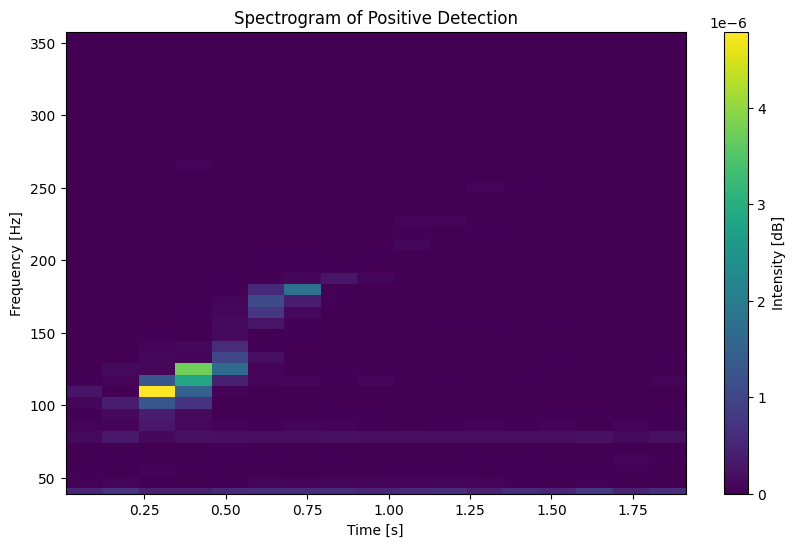

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram


# Extract the segment of the WAV file corresponding to the positive detection
data_segment = y[start_offset:end_offset]

# Compute the spectrogram for the segment of data
frequencies, times, Sxx = spectrogram(data_segment, sr)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, Sxx, shading='auto')
plt.colorbar(label='Intensity [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Spectrogram of Positive Detection')
plt.ylim(39.06, 357.56)  # Limit y-axis to Nyquist frequency
plt.show()



We must use the parameters specified by previous works, specifically set for the monitoring of NARW upcalls. 

From 'Deep neural networks for automated detection of marine mammal species'

Data preparation. Training examples consisted of spectrograms (128 ms Hann window, 50 ms advance) of 2 s sound clips with a frequency range from 39.06 to 357.56Hz, resulting in a 40 × 40 matrix of time-frequency magnitude values. We normalized the matrix by dividing each element by the sum of the squared elements in the matrix. 

approach: 

* use Short-Time Fourier Transform - take longer singal, break it up intom smaller time windows and compute fourier transform over the smaller time windows. 
* Hann window - applied to every frame before taking FFT to ensure smooth transitions between frames
    * if no smoothing is applied, we can think of it as the rectangular window, which can lead to discontinuities and artifacts in the spectrogram
    * using windows that tend towards zero around the boundaries prevents this from occuring.
    * hann window is a raised cosine window, dropping smoothly to zero at the section boundaries. This softens the artifacts in the fourier transform of the windowed signal
    * one downside is the hann window introduces some smearing of the frequencies 

In [ ]:
hann_window = 0.128 
frequency_range = [39.06, 357.56]

# Compute the spectrogram
frequencies, times, Sxx = spectrogram(data_segment, fs=sr, window='hann', 
                        nperseg=256,  # 128 ms window 0.128 * 2000 sr
                        noverlap=256 - 100)  # 50 ms advance 0.05 * 2000 sr
freq_mask = (frequencies >= 39.06) & (frequencies <= 357.56)
# limit freq
frequencies = frequencies[freq_mask]
Sxx = Sxx[freq_mask, :]
# normalize
Sxx /= np.sum(np.square(Sxx))

print(frequencies.shape)
print(times.shape)
print(Sxx.shape)
# Plot the spectrogram
# plt.figure(figsize=(10, 6))
# plt.pcolormesh(times, frequencies, Sxx, shading='auto')
# plt.colorbar(label='Intensity [dB]')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [s]')
# plt.title('Spectrogram of Positive Detection hann window')
# plt.ylim(39.06, 357.56)  # Limit y-axis to Nyquist frequency
# plt.show()



(41,)
(38,)
(41, 38)


Visualize processed dataset. (Positive samples!)

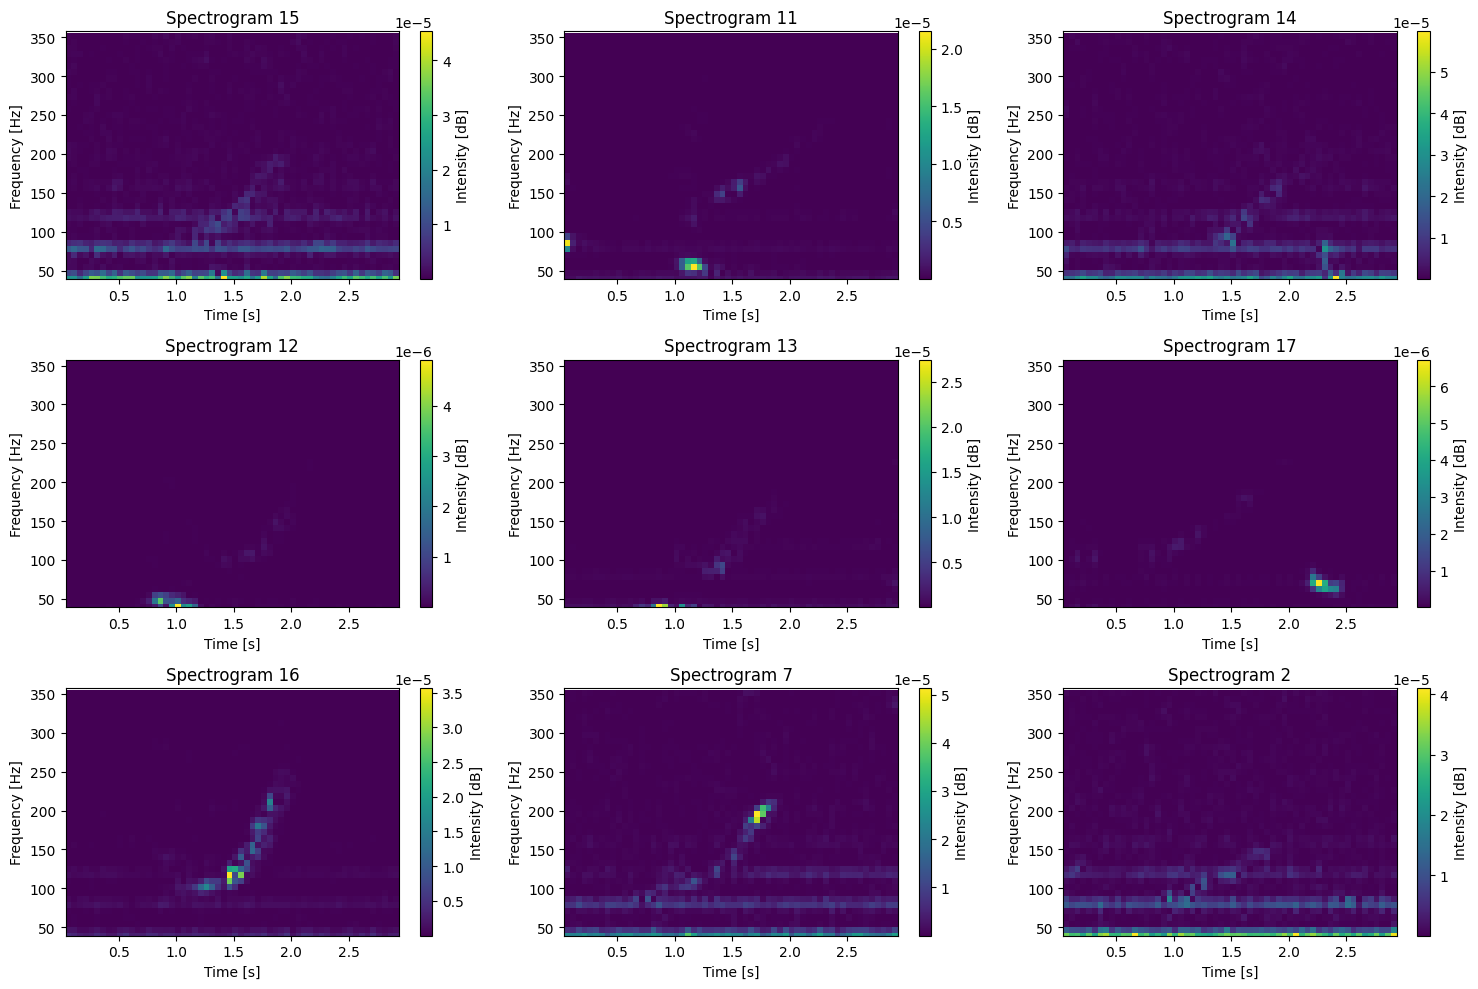

In [ ]:
positive_samples = np.load(r"C:\Users\NoahB\OneDrive\Desktop\cetacean_detection\nefsc_sbnms_200903_nopp6_ch10\processed\Detected.npz") 
frequencies = positive_samples['frequencies']
times = positive_samples['times']
Sxx = positive_samples['Sxx']

# Randomly select 9 indices from the Sxx array
indices = np.random.choice(len(Sxx), size=9, replace=False)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Loop through the 3x3 grid and plot the random samples
for i, ax in enumerate(axes.flat):
    idx = indices[i]  # Get the random index
    ax.pcolormesh(times[idx], frequencies[idx], Sxx[idx], shading='auto')
    ax.set_title(f'Spectrogram {idx}')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_ylim(39.06, 357.56)  # Limit y-axis to Nyquist frequency
    fig.colorbar(ax.pcolormesh(times[idx], frequencies[idx], Sxx[idx], shading='auto'), ax=ax, label='Intensity [dB]')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

Visualize negative samples!

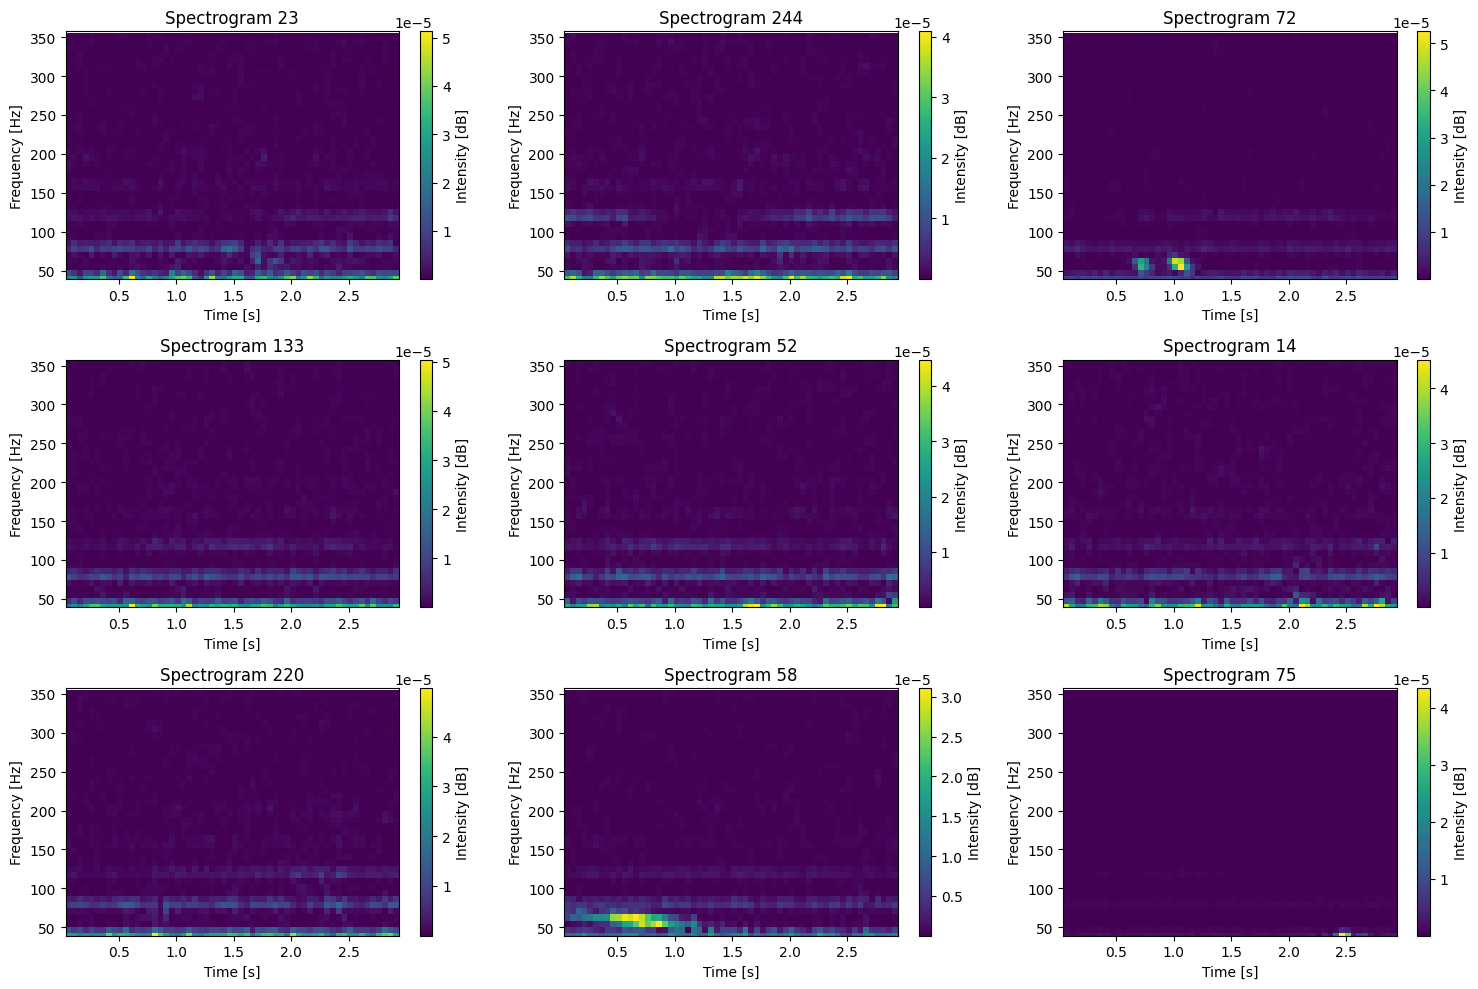

In [13]:
negative_samples = np.load(r"C:\Users\NoahB\OneDrive\Desktop\cetacean_detection\nefsc_sbnms_200903_nopp6_ch10\processed\Not Detected.npz") 
frequencies = negative_samples['frequencies']
times = negative_samples['times']
Sxx = negative_samples['Sxx']

# Randomly select 9 indices from the Sxx array
indices = np.random.choice(len(Sxx), size=9, replace=False)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Loop through the 3x3 grid and plot the random samples
for i, ax in enumerate(axes.flat):
    idx = indices[i]  # Get the random index
    ax.pcolormesh(times[idx], frequencies[idx], Sxx[idx], shading='auto')
    ax.set_title(f'Spectrogram {idx}')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_ylim(39.06, 357.56)  # Limit y-axis to Nyquist frequency
    fig.colorbar(ax.pcolormesh(times[idx], frequencies[idx], Sxx[idx], shading='auto'), ax=ax, label='Intensity [dB]')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

Visualize possibly detected samples!

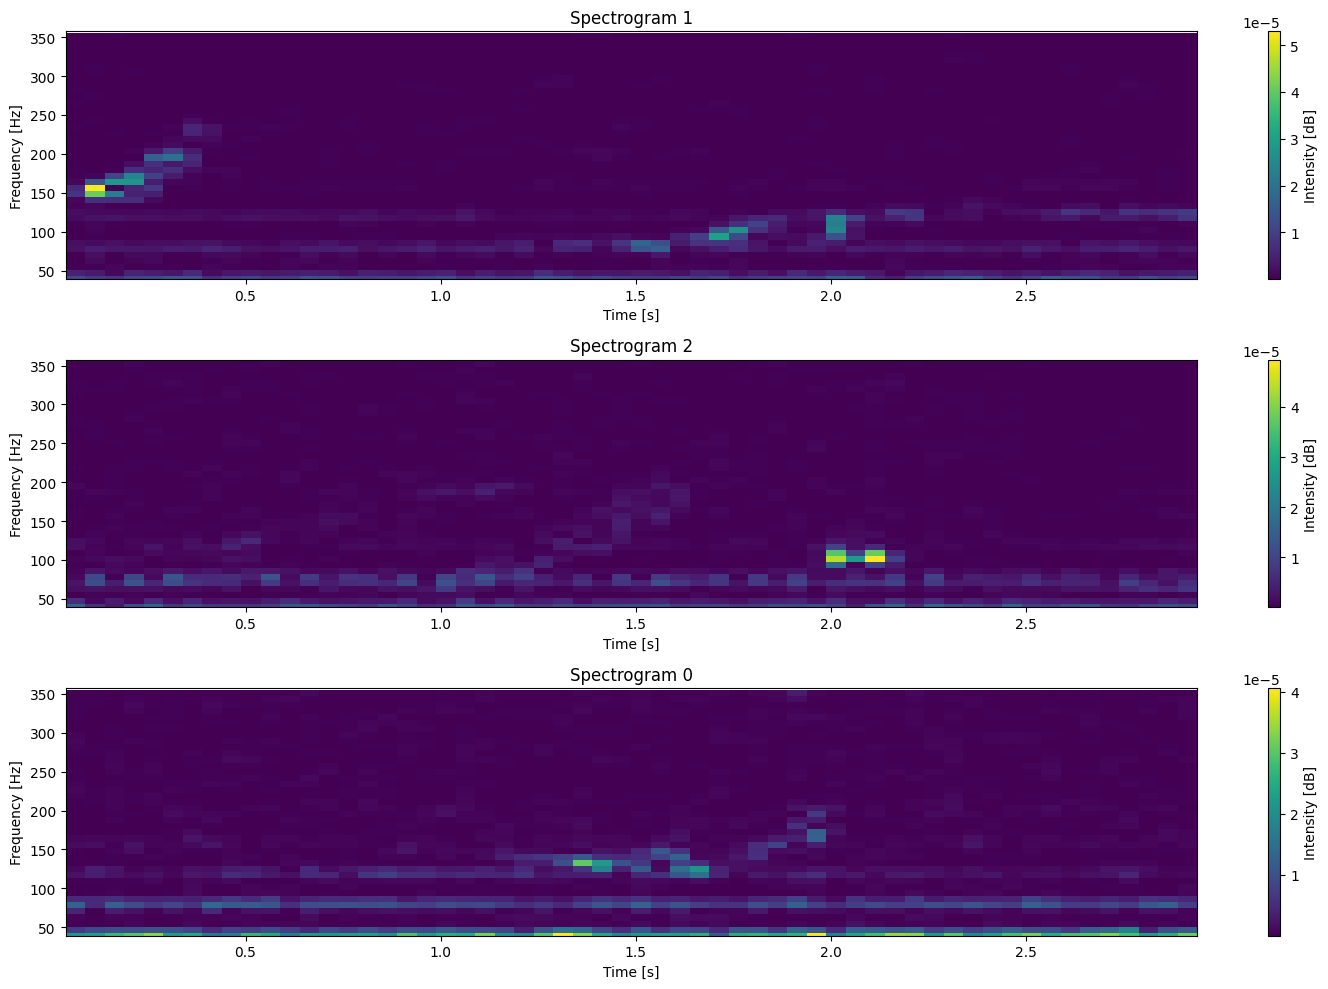

In [ ]:
possible_samples = np.load(r"C:\Users\NoahB\OneDrive\Desktop\cetacean_detection\nefsc_sbnms_200903_nopp6_ch10\processed\Possibly_Detected.npz") 
frequencies = possible_samples['frequencies']
times = possible_samples['times']
Sxx = possible_samples['Sxx']

# Randomly select 9 indices from the Sxx array
indices = np.random.choice(len(Sxx), size=3, replace=False)

# Create a 3 grid of subplots
fig, axes = plt.subplots(3, figsize=(15, 10))

# Loop through the 3 grid and plot the random samples
for i, ax in enumerate(axes.flat):
    idx = indices[i]  # Get the random index
    ax.pcolormesh(times[idx], frequencies[idx], Sxx[idx], shading='auto')
    ax.set_title(f'Spectrogram {idx}')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_ylim(39.06, 357.56)  # Limit y-axis to Nyquist frequency
    fig.colorbar(ax.pcolormesh(times[idx], frequencies[idx], Sxx[idx], shading='auto'), ax=ax, label='Intensity [dB]')

# Adjust layout for better readability
plt.tight_layout()

# Show the plot
plt.show()